This notebook is part of the deepcell-tf documentation: https://deepcell.readthedocs.io/.

# Training a cell tracking model

Implementation of: [Accurate cell tracking and lineage construction in live-cell imaging experiments with deep learning](https://www.biorxiv.org/content/10.1101/803205v2)


In [1]:
import os
import deepcell

import tensorflow as tf
import numpy as np

## Load the data

### Download data from deepcell.datasets

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models. All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed`, which is used to generate the random train-test split. Metadata associated with the dataset can be accessed through the `metadata` attribute.

Tracked data are stored as `.trks` files. These files include images and lineage data in np.arrays. To manipulate `.trks` files, use `deepcell.utils.tracking_utils.load_trks` and `deepcell.utils.tracking_utils.save_trks`.

In [2]:
# Download sample tracking data (saves to ~/.keras/datasets)
data_dir = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
filename = 'sample_tracking.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracking.load_tracked_data(filename)

# Load and view stats on this file
from deepcell.utils.tracking_utils import trks_stats, load_trks

path = os.path.join(data_dir, filename)
trks_stats(path)
trks_data = load_trks(path)

Dataset Statistics: 
Image data shape:  (722, 40, 216, 256, 1)
Number of lineages (should equal batch size):  722
Total number of unique tracks (cells)      -  11393
Total number of divisions                  -  855
Average cell density (cells/100 sq pixels) -  0.01694895003751154
Average number of frames per track         -  25


## Create Track objects

To facilitate training, we transform the images and lineage data into `Tracks` that store information about each cell in each movie. 

`# TODO:` Describe the shapes (batches, num of cells, etc)

In [3]:
from deepcell_tracking.utils import Track, concat_tracks

all_tracks = Track(tracked_data=trks_data)

track_info = concat_tracks([all_tracks])
for k, v in track_info.items():
    print(k, v.shape)

appearances (688, 40, 39, 32, 32, 1)
centroids (688, 40, 39, 2)
morphologies (688, 40, 39, 3)
adj_matrices (688, 40, 39, 39)
norm_adj_matrices (688, 40, 39, 39)
temporal_adj_matrices (688, 39, 39, 39, 3)


## Create Tracking Dataset object

We then assemble `Tracks` as specified into a Tracking `Dataset` that is used during training

In [4]:
from deepcell.data.tracking import prepare_dataset

# Get max_cells for dataset
max_cells = track_info['appearances'].shape[2]

# Prepare the dataset
train_data, val_data, test_data = prepare_dataset(track_info,
                                                  rotation_range=0, 
                                                  translation_range=0,
                                                  batch_size=4,
                                                  track_length=8)

## Set up file path constants

In [5]:
import errno

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Set up training parameters

In [6]:
train_seed = 1   # Random seed for training/validation data split -> this may need to be in dataset obj
test_size = .20  # % of data saved as validation
n_epochs = 20     # Number of training epochs
steps_per_epoch = 512
validation_steps = 100

model_name = 'graph_tracking_model_seed{}'.format(train_seed)
model_path = os.path.join(MODEL_DIR, model_name)

## Instantiate and Compile the Model
The goal is to predict the adjacency matrix and daughter adjacency matrix by attending over the edges provided by the spatiotemporal adjacency matrix (SAM). The SAM is constructed by linking cells that are in temporal or spatial proximity.

In [7]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel(max_cells=max_cells, n_layers=1)  # n_layers = number of graph convolutions

Before a model must be trained, it must be compiled with the chosen optimizer, loss function, and metrics.

In [8]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam

from deepcell import train_utils
from deepcell.losses import wce_for_adj_mat

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)

# Define the loss function
losses = {'temporal_adj_matrices': wce_for_adj_mat}

In [9]:
class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        n_classes = tf.shape(y_true)[-1]
        new_shape = [-1, n_classes]
        y_true = tf.reshape(y_true, new_shape)
        y_pred = tf.reshape(y_pred, new_shape)

        # Mask out the padded cells
        good_loc = tf.where(y_true[:, 0] != -1)[:, 0]

        y_true = tf.gather(y_true, good_loc, axis=0)
        y_pred = tf.gather(y_pred, good_loc, axis=0)
        super(Recall, self).update_state(y_true, y_pred, sample_weight)


class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        n_classes = tf.shape(y_true)[-1]
        new_shape = [-1, n_classes]
        y_true = tf.reshape(y_true, new_shape)
        y_pred = tf.reshape(y_pred, new_shape)

        # Mask out the padded cells
        good_loc = tf.where(y_true[:, 0] != -1)

        y_true = tf.gather(y_true, good_loc[:,0], axis=0)
        y_pred = tf.gather(y_pred, good_loc[:,0], axis=0)
        super(Precision, self).update_state(y_true, y_pred, sample_weight)

# Define metrics
metrics = [
    Recall(class_id=0, name='same_recall'),
    Recall(class_id=1, name='different_recall'),
    Recall(class_id=2, name='daughter_recall'),
    Precision(class_id=0, name='same_precision'),
    Precision(class_id=1, name='different_precision'),
    Precision(class_id=2, name='daughter_precision'),
]

In [10]:
# Compile model
tm.training_model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Train Model and Verify Performance

Call fit on the compiled model, along with a defined set of callbacks.

In [11]:
# Verify GPU count
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Train the model
train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = tm.training_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)


Training on 1 GPUs
Epoch 1/20
512/512 [==============================] - 86s 120ms/step - loss: 0.5814 - same_recall: 0.9149 - different_recall: 0.6381 - daughter_recall: 0.4166 - same_precision: 0.1416 - different_precision: 0.9932 - daughter_precision: 0.0100 - val_loss: 0.1306 - val_same_recall: 0.9981 - val_different_recall: 0.9701 - val_daughter_recall: 0.7059 - val_same_precision: 0.6894 - val_different_precision: 1.0000 - val_daughter_precision: 0.0153

Epoch 00001: val_loss improved from inf to 0.13062, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 2/20
512/512 [==============================] - 58s 114ms/step - loss: 0.1793 - same_recall: 0.9912 - different_recall: 0.9917 - daughter_recall: 0.6708 - same_precision: 0.8539 - different_precision: 0.9999 - daughter_precision: 0.0809 - val_loss: 0.0730 - val_same_recall: 0.9917 - val_different_recall: 0.9935 - val_daughter_recall: 0.8826 - val_same_precision: 0.9645 - val_different_precision: 1.0000 - val_daughter_precision: 0.0429

Epoch 00002: val_loss improved from 0.13062 to 0.07303, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 3/20
512/512 [==============================] - 58s 114ms/step - loss: 0.1456 - same_recall: 0.9900 - different_recall: 0.9967 - daughter_recall: 0.7629 - same_precision: 0.9426 - different_precision: 0.9999 - daughter_precision: 0.1167 - val_loss: 0.2717 - val_same_recall: 0.9982 - val_different_recall: 0.9993 - val_daughter_recall: 0.4244 - val_same_precision: 0.9798 - val_different_precision: 0.9999 - val_daughter_precision: 0.7157

Epoch 00003: val_loss did not improve from 0.07303
Epoch 4/20
512/512 [==============================] - 59s 114ms/step - loss: 0.1473 - same_recall: 0.9951 - different_recall: 0.9979 - daughter_recall: 0.7252 - same_precision: 0.9625 - different_precision: 0.9999 - daughter_precision: 0.1815 - val_loss: 0.2172 - val_same_recall: 0.9981 - val_different_recall: 0.9997 - val_daughter_recall: 0.3735 - val_same_precision: 0.9895 - val_different_precision: 0.9999 - val_daughter_precision: 0.8267

Epoch 00004: val_loss did not improve from 0.07303
Epoch 

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 10/20
512/512 [==============================] - 58s 113ms/step - loss: 0.0814 - same_recall: 0.9972 - different_recall: 0.9995 - daughter_recall: 0.8528 - same_precision: 0.9912 - different_precision: 0.9999 - daughter_precision: 0.4929 - val_loss: 0.0656 - val_same_recall: 0.9987 - val_different_recall: 0.9996 - val_daughter_recall: 0.8276 - val_same_precision: 0.9928 - val_different_precision: 1.0000 - val_daughter_precision: 0.5496

Epoch 00010: val_loss did not improve from 0.02888
Epoch 11/20
512/512 [==============================] - 58s 114ms/step - loss: 0.0757 - same_recall: 0.9972 - different_recall: 0.9995 - daughter_recall: 0.8309 - same_precision: 0.9898 - different_precision: 0.9999 - daughter_precision: 0.4734 - val_loss: 0.1054 - val_same_recall: 0.9990 - val_different_recall: 0.9998 - val_daughter_recall: 0.7684 - val_same_precision: 0.9940 - val_different_precision: 1.0000 - val_daughter_precision: 0.8889

Epoch 00011: val_loss did not improve from 0.02888
Epoc

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 14/20
512/512 [==============================] - 59s 114ms/step - loss: 0.0700 - same_recall: 0.9979 - different_recall: 0.9997 - daughter_recall: 0.8727 - same_precision: 0.9928 - different_precision: 1.0000 - daughter_precision: 0.6238 - val_loss: 0.0333 - val_same_recall: 0.9986 - val_different_recall: 0.9997 - val_daughter_recall: 0.9366 - val_same_precision: 0.9917 - val_different_precision: 1.0000 - val_daughter_precision: 0.6751

Epoch 00014: val_loss did not improve from 0.02447
Epoch 15/20
512/512 [==============================] - 59s 114ms/step - loss: 0.0580 - same_recall: 0.9978 - different_recall: 0.9996 - daughter_recall: 0.8676 - same_precision: 0.9914 - different_precision: 1.0000 - daughter_precision: 0.6047 - val_loss: 0.0888 - val_same_recall: 0.9978 - val_different_recall: 0.9998 - val_daughter_recall: 0.8144 - val_same_precision: 0.9942 - val_different_precision: 0.9999 - val_daughter_precision: 0.7047

Epoch 00015: val_loss did not improve from 0.02447
Epoc

Visualize the performance of the model by comparing the predicted classes of i frames in j movies

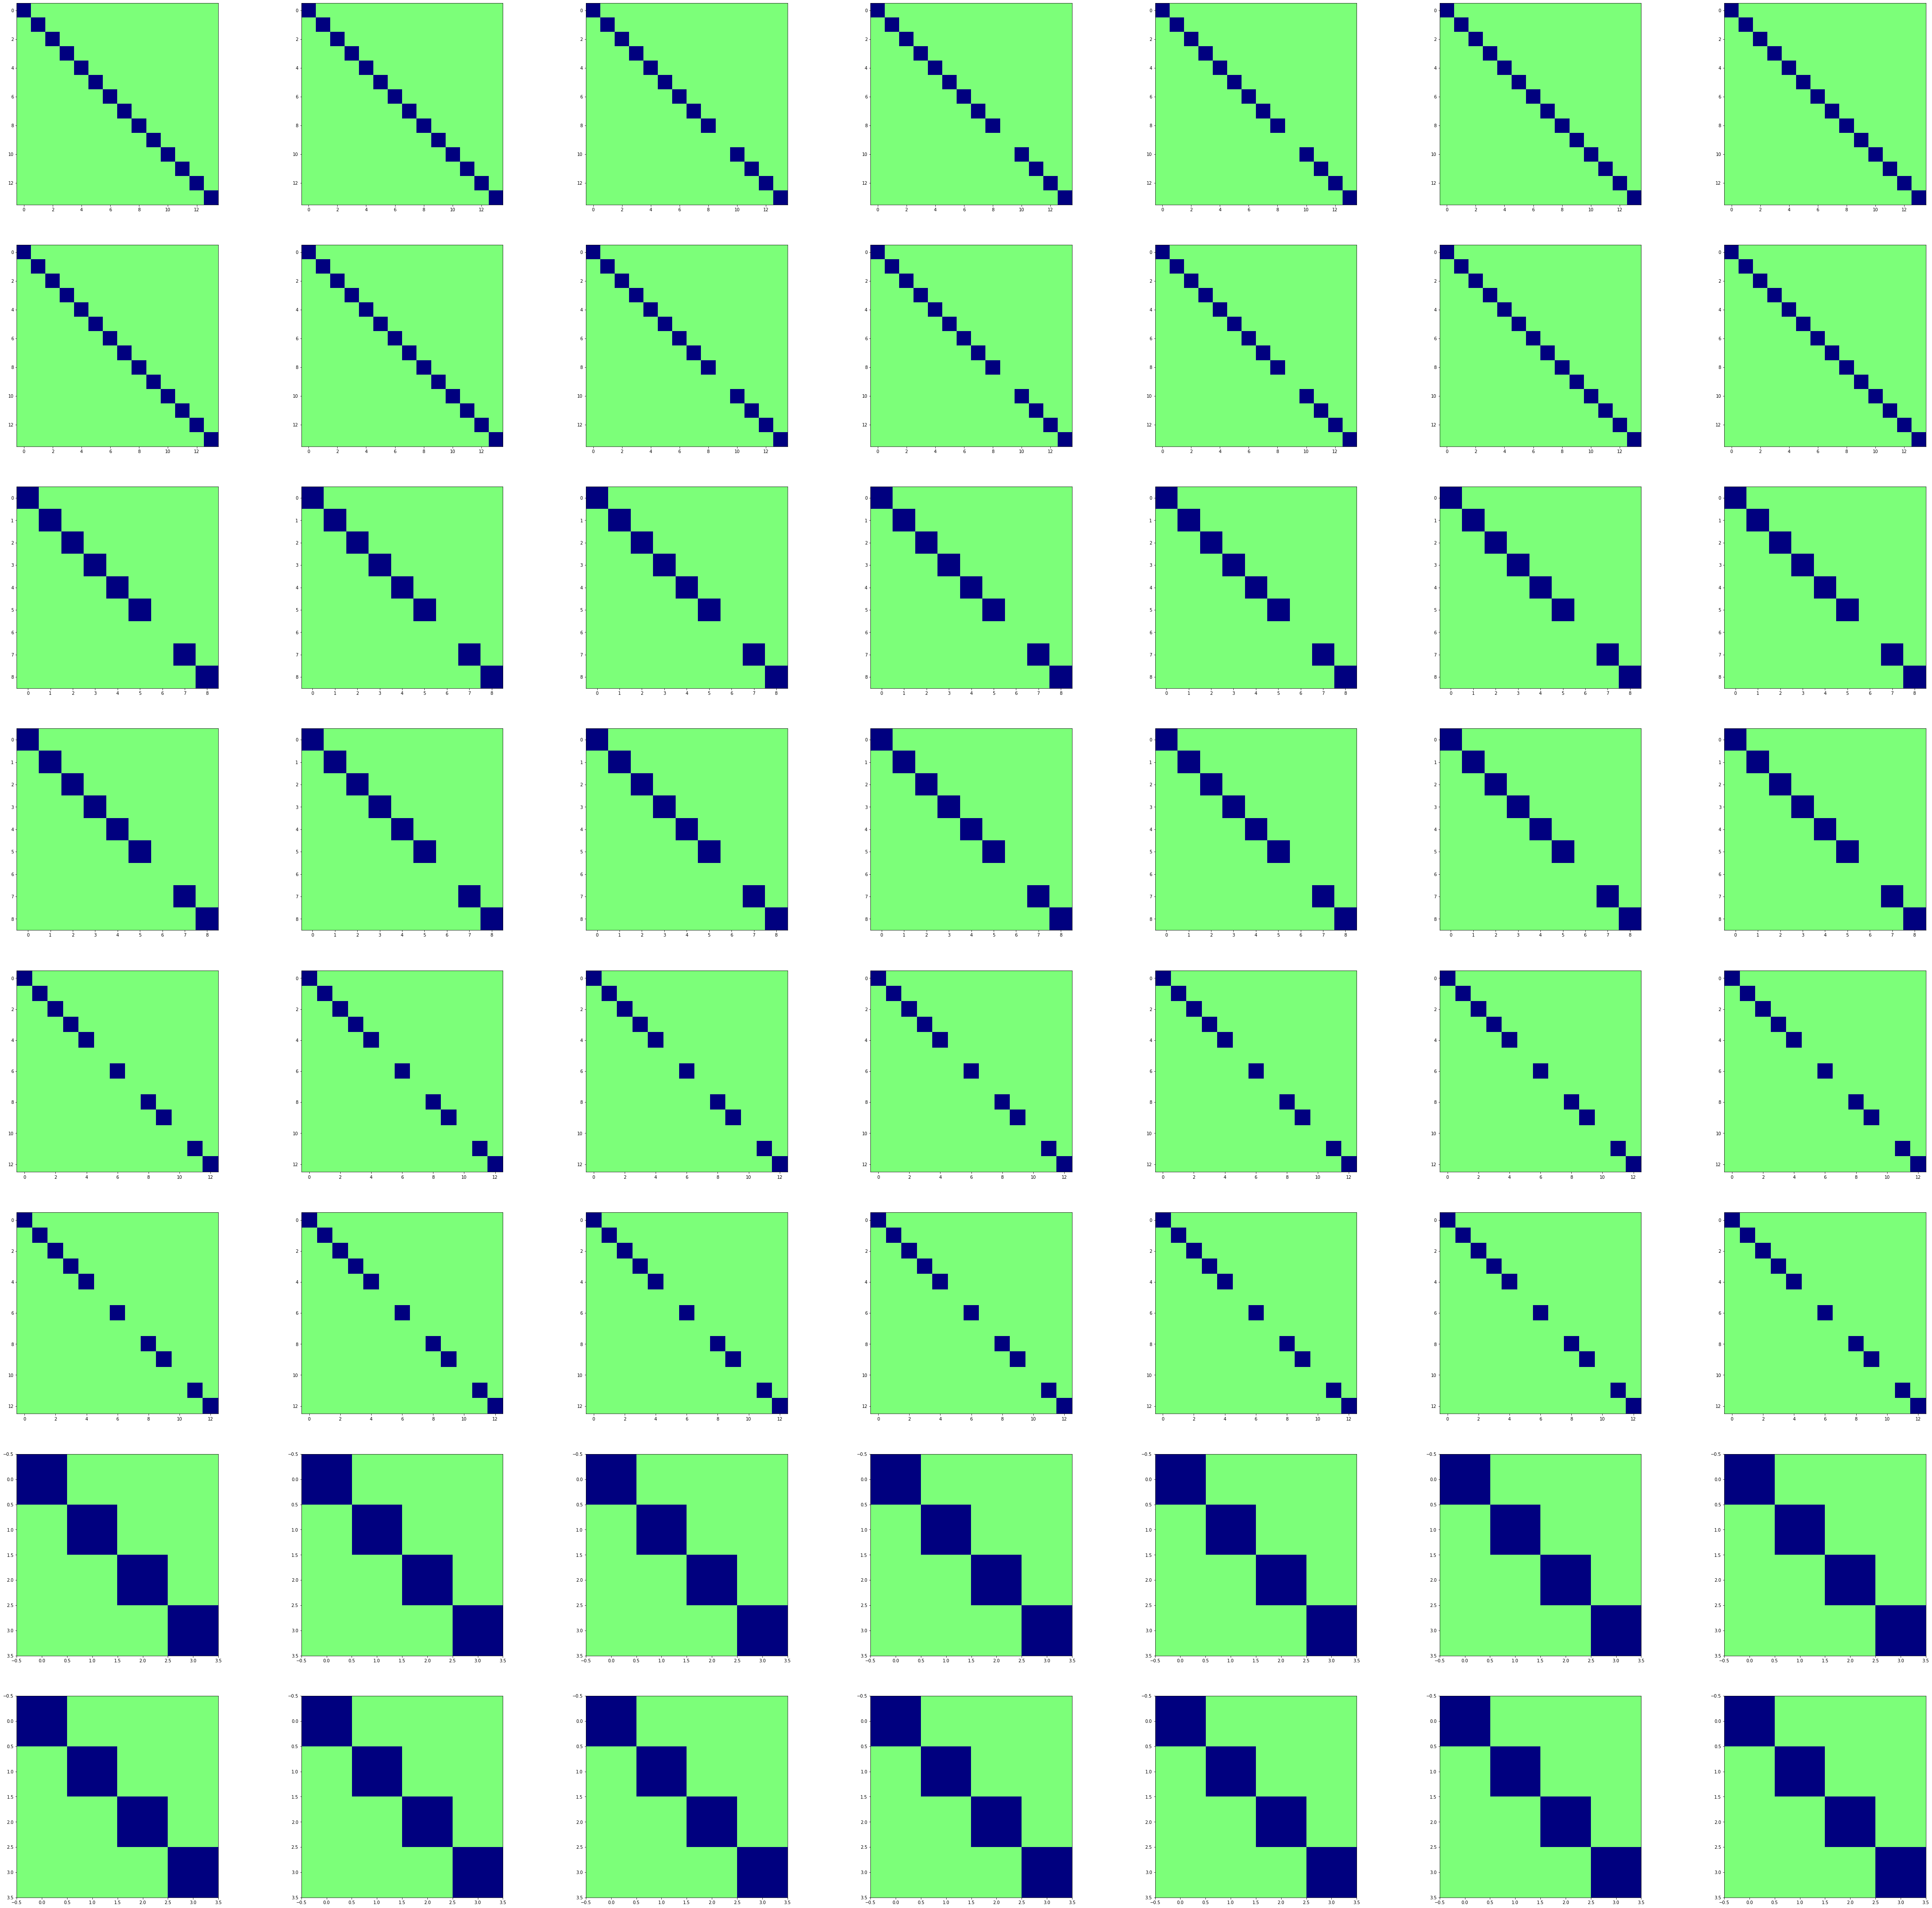

In [15]:
from matplotlib import pyplot as plt

it = val_data.as_numpy_iterator()
x_temp, y_temp = it.next()

temp_adj = y_temp['temporal_adj_matrices']

output = tm.training_model.predict(x_temp)

fig, axes = plt.subplots(8,7,figsize=(80,80))

for j in range(4):
    for i in range(7):
        pred = output[j,i,:,:,:]
        truth = temp_adj[j,i,:,:,:]

        summed = np.sum(truth, axis=-1)
        bad_loc = np.where(summed==-3)[1]
        end = bad_loc[0]-1
        summed = np.sum(truth, axis=-1)

        axes[2*j,i].imshow(np.argmax(pred[0:end,0:end,:], axis=-1), cmap='jet', vmin=0, vmax=2)
        axes[2*j+1,i].imshow(np.argmax(truth[0:end,0:end,:]==1, axis=-1), cmap='jet', vmin=0, vmax=2)

## Save the Model

In [16]:
# Save models for prediction
inf_path = '/TrackingModelInf'
ne_path = '/TrackingModelNE'

tm.inference_model.save(inf_path)
tm.neighborhood_encoder.save(ne_path)

INFO:tensorflow:Assets written to: /data/users/erick/nuc_tracking/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/users/erick/nuc_tracking/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/users/erick/nuc_tracking/TrackingModelNE/assets


INFO:tensorflow:Assets written to: /data/users/erick/nuc_tracking/TrackingModelNE/assets


## Next Steps

This model is used within an assignment problem framework to track cells through time-lapse sequences and build cell lineages. To see how this works on example data, see below. 

To use existing models for tracking (and segmentation), refer to its counterpart in the `deepcell.application` [notebook series](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Nuclear-Application.ipynb).

## Load the Model and Track One Movie

In [17]:
# Instantiate Models
from deepcell.model_zoo.tracking import GNNTrackingModel
tm = GNNTrackingModel()

# Load models for prediction (re-write paths if different from above)
# inf_path = ''
# ne_path = ''

tm.neighborhood_encoder = tf.keras.models.load_model(ne_path)
tm.inference_model = tf.keras.models.load_model(inf_path)

Load a segmented movie from `deepcell.datasets` to track

In [26]:
# Choose and load a dataset to track using the trained model
filename_hek_bench = 'HEK293_benchmarks.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.hek293_bench.load_tracked_data(filename_hek_bench)
print('HEK293 -\nX.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

data_dir = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
path_bench_trks = os.path.join(data_dir, filename_hek_bench)
test_data_hek = load_trks(path_bench_trks)

raw_images = test_data_hek['X'][1]
labeled_movie = test_data_hek['y'][1]

HEK293 -
X.shape: (20, 30, 135, 160, 1)
y.shape: (20, 30, 135, 160, 1)


### Import the cell tracking algorithm and track the movie

In [27]:
from deepcell_tracking import CellTracker

cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=8,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [28]:
%%time

cell_tracker.track_cells()

CPU times: user 2.61 s, sys: 177 ms, total: 2.79 s
Wall time: 2.25 s


### Review the results

In [29]:
# View tracked results of each batch as a video
# NB: This does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(raw_images, axis=0), batch=0, cmap='gray'))

In [31]:
# Tracked

# Scale the colors to match the max cell label
vmax = len(cell_tracker.tracks.keys())
HTML(get_js_video(np.expand_dims(cell_tracker.y_tracked, axis=0), batch=0, cmap='cubehelix', vmin=0, vmax=vmax))

# Save the Output

If desired, save the results in our compressed format (.trk - with lineage information), as a movie (.gif - images only/no lineage information), or both

In [ ]:
# Define file path constants
NUC_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

# create directory if does not exist
try:
    os.makedirs(NUC_DIR)
except OSError as exc:  # Guard against race condition
    if exc.errno != errno.EEXIST:
        raise

# Define where trk file will be saved
res_file_name = 'hek_res.trk'
res_file_path = os.path.join(NUC_DIR, res_file_name)

In [32]:
# Save trk file
res_file_path = '/hek_test.trk'
cell_tracker.dump(res_file_path)

In [33]:
# Save stacks
import imageio
vmax = len(cell_tracker.tracks.keys())
raw = []
tracked = []
for i in range(cell_tracker.X.shape[0]):
    new_image = cell_tracker.X[i,...,0]
    imageio.imwrite('/image_%d.tiff' %i, new_image)
    raw.append(new_image)
    
    label_image = cell_tracker.y_tracked[i,...,0]
#    imageio.imwrite('/label_%d.tiff' %i, label_image, cmap='cubehelix', vmin=0, vmax=vmax)
    plt.imsave('/label_%d.tiff' %i, label_image, cmap='cubehelix', vmin=0, vmax=vmax)
    tracked.append(label_image)
    
# Make gifs
imageio.mimsave('/raw.gif', raw)
imageio.mimsave('/tracked.gif', tracked)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

Lossy conversion from int32 to uint8. Range [0, 122]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 122]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 128]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 128]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 

# Benchmark the Results

N.B. Requires the result to be saved to .trk file

In [41]:
# First, we'll need the ground truth to compare against 
# So we select and save a .trk from our set of tracks (.trks)
GT_trk_path = '/hek_test_gt.trk'

gt_trk = {}
gt_trk['X'] = test_data_hek['X'][1]
gt_trk['y_tracked'] = test_data_hek['y'][1]
gt_trk['tracks'] = test_data_hek['lineages'][1]
# TODO: The following is a work around to save .trk file using CellTracker .dump method
GT_Tracker = CellTracker(movie=raw_images, annotation=labeled_movie, neighborhood_encoder=tm.neighborhood_encoder, tracking_model=tm.inference_model)
GT_Tracker.dump(filename=GT_trk_path, track_review_dict=gt_trk)


In [42]:
Res_trk_path = res_file_path
# GT_trk_path = ''

from deepcell_tracking.isbi_utils import benchmark_division_performance

results = benchmark_division_performance(GT_trk_path, Res_trk_path)
print(results)

missed node 21_21 division completely
{'Correct division': 2, 'Incorrect division': 0, 'False positive division': 0, 'False negative division': 1}
